4983


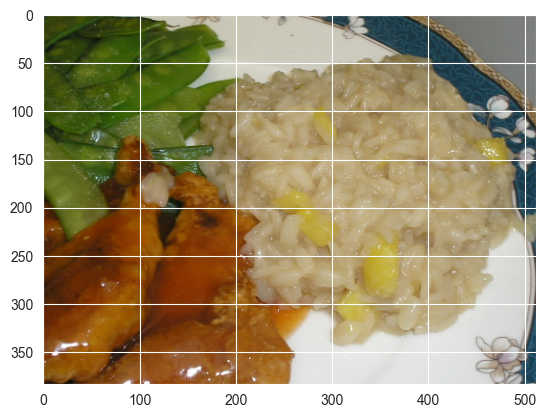

In [21]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from datasets import load_dataset
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dataset = load_dataset("EduardoPacheco/FoodSeg103")

train_dataset, validate_dataset = dataset["train"], dataset["validation"]

print(len(train_dataset))

img = train_dataset[0]["image"]
plt.imshow(img)


In [22]:
import numpy as np
def extract_ingredients(chosen_images):
    mask = np.array(chosen_images["label"])
    unique_labels = np.unique(mask)
    # we also filter out category 0, since 0 = background
    unique_labels = unique_labels[unique_labels != 0]
    chosen_images["ingredients"] = unique_labels.tolist()
    return chosen_images

train = train_dataset.map(extract_ingredients)
validation = validate_dataset.map(extract_ingredients)

In [23]:
num_of_classes = 104

def one_hot_encode(example):
    ingredient_vector = np.zeros(num_of_classes, dtype=np.float32)
    for cls in example["ingredients"]:
        ingredient_vector[int(cls)] = 1.0
    example["ingredient_vector"] = ingredient_vector
    return example

train = train.map(one_hot_encode)
validation = validation.map(one_hot_encode)

In [24]:
from PIL import Image

IMG_SIZE = 224
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

def preprocess_img(img,mask):
    """
    Resize image to 224x224 and convert to PyTorch tensor.
    Args:
        img: PIL Image or numpy array
    Returns:
        torch.Tensor: Image tensor ready for PyTorch
    """

    if not isinstance(img, Image.Image):
        img = Image.fromarray(img)
    if not isinstance(mask, Image.Image):
        mask = Image.fromarray(mask)

    return transform(img),transform(mask)

def preprocess(v):
    img = v["image"]
    if not isinstance(img, Image.Image):
        img = Image.fromarray(img)
    v["image"] = transform(img)
    return v

In [28]:
small_train_ds = train.select(range(1000))
small_val_ds = validation.select(range(500))

train_torch = small_train_ds.map(preprocess)
validation_torch = small_val_ds.map(preprocess)


Map: 100%|██████████| 500/500 [00:23<00:00, 21.28 examples/s] 


In [26]:
from torchvision.models import resnet50, ResNet50_Weights

model = resnet50(weights=ResNet50_Weights.DEFAULT)


In [38]:
from torch.utils.data import DataLoader

batch_size = 32

train_torch.set_format(type="torch", columns=["image", "label", "classes_on_image", "ingredients", "ingredient_vector", "id"])
validation_torch.set_format(type="torch", columns=["image", "label", "classes_on_image","ingredients", "ingredient_vector", "id"])

train_dataloader = DataLoader(train_torch, batch_size=batch_size)
validate_dataloader = DataLoader(validation_torch, batch_size=batch_size)
print(train_torch[0].keys())

dict_keys(['image', 'label', 'classes_on_image', 'id', 'ingredients', 'ingredient_vector'])
